# WangchanBERTa: Getting Started Notebook


This is a developing Getting Started Notebook for WangchanBERTa. Currently it has inference methods you can easily use from [HuggingFace](http://huggingface.co/). We will add pretraining and finetuning methods from the scripts in [vistec-ai/thai2transformers](https://github.com/vistec-AI/thai2transformers).

![WangchanBERTa](https://miro.medium.com/max/2400/1*XAHtR9rKv8SJ4ESELxm2iQ.png)

# Installation

Install dependencies at specific versions to make sure WangchanBERTa works.

In [1]:
# # Install transformers and thai2transformers
# !pip install transformers
# !pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
# !pip install --no-deps thai2transformers==0.1.2

In [2]:
import numpy as np
from tqdm.auto import tqdm
import torch

#transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
)

#thai2transformers
from thai2transformers.preprocess import process_transformers
from thai2transformers.metrics import (
    classification_metrics,
    multilabel_classification_metrics,
)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer,
    SEFR_SPLIT_TOKEN
)

# Choose Pretrained Model

In this notebook, you can choose from 5 versions of WangchanBERTa, XLMR and mBERT to perform downstream tasks with Thai datasets. The datasets are:

* `wangchanberta-base-att-spm-uncased` (recommended) - Largest WangchanBERTa trained on 78.5GB of Assorted Thai Texts with subword tokenizer SentencePiece
* `xlm-roberta-base` - Facebook's [XLMR](https://arxiv.org/abs/1911.02116) trained on 100 languages
* `bert-base-multilingual-cased` - Google's [mBERT](https://arxiv.org/abs/1911.03310) trained on 104 languages
* `wangchanberta-base-wiki-newmm` - WangchanBERTa trained on Thai Wikipedia Dump with PyThaiNLP's word-level tokenizer  `newmm`
* `wangchanberta-base-wiki-syllable` - WangchanBERTa trained on Thai Wikipedia Dump with PyThaiNLP's syllabel-level tokenizer `syllable`
* `wangchanberta-base-wiki-sefr` - WangchanBERTa trained on Thai Wikipedia Dump with word-level tokenizer  `SEFR`
* `wangchanberta-base-wiki-spm` - WangchanBERTa trained on Thai Wikipedia Dump with subword-level tokenizer SentencePiece

In [3]:
model_names = [
    'wangchanberta-base-att-spm-uncased',
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'wangchanberta-base-wiki-newmm',
    'wangchanberta-base-wiki-ssg',
    'wangchanberta-base-wiki-sefr',
    'wangchanberta-base-wiki-spm',
]

tokenizers = {
    'wangchanberta-base-att-spm-uncased': AutoTokenizer,
    'xlm-roberta-base': AutoTokenizer,
    'bert-base-multilingual-cased': AutoTokenizer,
    'wangchanberta-base-wiki-newmm': ThaiWordsNewmmTokenizer,
    'wangchanberta-base-wiki-ssg': ThaiWordsSyllableTokenizer,
    'wangchanberta-base-wiki-sefr': FakeSefrCutTokenizer,
    'wangchanberta-base-wiki-spm': ThaiRobertaTokenizer,
}
public_models = ['xlm-roberta-base', 'bert-base-multilingual-cased']
#@title Choose Pretrained Model
model_name = "wangchanberta-base-att-spm-uncased" #@param ["wangchanberta-base-att-spm-uncased", "xlm-roberta-base", "bert-base-multilingual-cased", "wangchanberta-base-wiki-newmm", "wangchanberta-base-wiki-syllable", "wangchanberta-base-wiki-sefr", "wangchanberta-base-wiki-spm"]

#create tokenizer
tokenizer = tokenizers[model_name].from_pretrained(
                f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
                revision='main',
                model_max_length=416,)


## Zero-shot Text Classification

Zero-shot text classification is a fancy way of saying "do similarity search with a given set of labels based on pretrained model outputs". It maybe useful when you do not have any training data to finetune at all. Here is how you can do it.

<br>

__Updated on Friday 26 March 2021__: We have released WanchanBERTa, XLMR and mBERT models finetuned on [XNLI](https://github.com/facebookresearch/XNLI) dataset ( Thai sentence pairs). The finetuned model checkpoints are stored under the branch named `finetuned@xnli_th` in our organization repositories (available at Huggingface Model Hub (https://huggingface.co/airesearch)).

In [4]:
#pipeline
zero_classify = pipeline(task='zero-shot-classification',
         tokenizer=tokenizer,
         model=AutoModelForSequenceClassification.from_pretrained(
             f'airesearch/{model_name}' if model_name not in public_models else f'airesearch/{model_name}-finetuned',
             revision='finetuned@xnli_th')
         )

In [5]:
zero_classify("‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏≠‡∏±‡∏ô‡∏ï‡∏£‡∏≤‡∏¢‡∏ó‡∏µ‡πà‡∏Ñ‡∏ß‡∏£‡∏´‡∏•‡∏µ‡∏Å‡πÄ‡∏•‡∏µ‡πà‡∏¢‡∏á‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏´‡πà‡∏≤‡∏á‡πÑ‡∏Å‡∏•‡∏°‡∏∞‡πÄ‡∏£‡πá‡∏á", candidate_labels=['‡∏Ç‡πà‡∏≤‡∏ß‡∏™‡∏∏‡∏Ç‡∏†‡∏≤‡∏û', '‡∏Ç‡πà‡∏≤‡∏ß‡∏Å‡∏µ‡∏¨‡∏≤', '‡∏Ç‡πà‡∏≤‡∏ß‡∏Å‡∏≤‡∏£‡πÄ‡∏°‡∏∑‡∏≠‡∏á'])

{'sequence': '‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏≠‡∏±‡∏ô‡∏ï‡∏£‡∏≤‡∏¢‡∏ó‡∏µ‡πà‡∏Ñ‡∏ß‡∏£‡∏´‡∏•‡∏µ‡∏Å‡πÄ‡∏•‡∏µ‡πà‡∏¢‡∏á‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏´‡πà‡∏≤‡∏á‡πÑ‡∏Å‡∏•‡∏°‡∏∞‡πÄ‡∏£‡πá‡∏á',
 'labels': ['‡∏Ç‡πà‡∏≤‡∏ß‡∏™‡∏∏‡∏Ç‡∏†‡∏≤‡∏û', '‡∏Ç‡πà‡∏≤‡∏ß‡∏Å‡∏≤‡∏£‡πÄ‡∏°‡∏∑‡∏≠‡∏á', '‡∏Ç‡πà‡∏≤‡∏ß‡∏Å‡∏µ‡∏¨‡∏≤'],
 'scores': [0.6291574239730835, 0.28126662969589233, 0.08957596123218536]}

In [6]:
zero_classify("‡∏¢‡∏±‡∏á‡∏Ñ‡∏£‡∏±‡∏ö", candidate_labels=['‡πÑ‡∏î‡πâ', '‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ ‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ'])

{'sequence': '‡∏¢‡∏±‡∏á‡∏Ñ‡∏£‡∏±‡∏ö',
 'labels': ['‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ ‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ', '‡πÑ‡∏î‡πâ'],
 'scores': [0.5756412744522095, 0.42435869574546814]}

# Chatbot

In [7]:
def intent_classifier(text_input, candidate_labels, zero_classify=zero_classify):
    input_text = process_transformers(text_input)
    output_label = zero_classify(input_text, candidate_labels=candidate_labels)
    return output_label['labels'][0]

## Section A

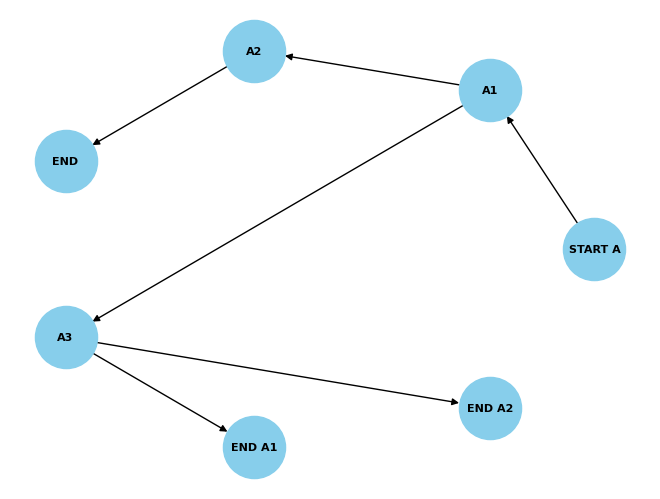

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

customer_name = "‡∏à‡∏¥‡∏£‡∏≤‡∏ô‡∏∏‡∏ß‡∏±‡∏í‡∏ô‡πå"
bot_identity = 'female'
bot_name = '‡∏ó‡πâ‡∏≠‡∏á‡∏ü‡πâ‡∏≤'
pronoun = '‡∏î‡∏¥‡∏â‡∏±‡∏ô' if bot_identity == 'female' else '‡∏Å‡∏£‡∏∞‡∏ú‡∏°'
sentence_ending = ['‡∏Ñ‡πà‡∏∞','‡∏Ñ‡∏∞'] if bot_identity == 'female' else ['‡∏Ñ‡∏£‡∏±‡∏ö','‡∏Ñ‡∏£‡∏±‡∏ö']
comany_name = '‡πÅ‡∏°‡∏ß‡πÄ‡∏´‡∏°‡∏µ‡∏¢‡∏ß'

# Create a directed graph
A = nx.DiGraph(section='A')

# Add nodes and edges
A.add_node("START A", response=f"‡∏™‡∏ß‡∏±‡∏™‡∏î‡∏µ{sentence_ending[0]} ‡∏Ç‡∏≠‡πÄ‡∏£‡∏µ‡∏¢‡∏ô‡∏™‡∏≤‡∏¢‡∏Ñ‡∏∏‡∏ì {customer_name} {sentence_ending[0]}")
A.add_node("A1", response=f"{pronoun} ‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏£‡∏≤‡∏ö‡∏Ç‡∏≠‡∏õ‡∏£‡∏∞‡∏ó‡∏≤‡∏ô‡πÇ‡∏ó‡∏©‡πÄ‡∏õ‡πá‡∏ô‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏™‡∏π‡∏á‡∏ó‡∏µ‡πà‡πÇ‡∏ó‡∏£‡∏°‡∏≤‡∏£‡∏ö‡∏Å‡∏ß‡∏ô‡∏ô‡∏∞{sentence_ending[1]} {pronoun} ‡∏ä‡∏∑‡πà‡∏≠ {bot_name} ‡πÉ‡∏ö‡∏≠‡∏ô‡∏∏‡∏ç‡∏≤‡∏ï‡∏ô‡∏≤‡∏¢‡∏´‡∏ô‡πâ‡∏≤‡∏õ‡∏£‡∏∞‡∏Å‡∏±‡∏ô‡∏ß‡∏¥‡∏ô‡∏≤‡∏®‡∏†‡∏±‡∏¢‡πÄ‡∏•‡∏Ç‡∏ó‡∏µ‡πà XXXXXXXXXX ‡∏ï‡∏¥‡∏î‡∏ï‡πà‡∏≠‡∏à‡∏≤‡∏Å‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó {comany_name} ‡∏à‡∏≥‡∏Å‡∏±‡∏î ‡πÇ‡∏ó‡∏£‡∏°‡∏≤‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏Ç‡∏≠‡∏≠‡∏ô‡∏∏‡∏ç‡∏≤‡∏ï‡∏ô‡∏≥‡πÄ‡∏™‡∏ô‡∏≠‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏õ‡∏£‡∏∞‡πÇ‡∏¢‡∏ä‡∏ô‡πå‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏•‡∏π‡∏Å‡∏Ñ‡πâ‡∏≤‡∏Ç‡∏≠‡∏á‡∏ò‡∏ô‡∏≤‡∏Ñ‡∏≤‡∏£{comany_name} ‡πÑ‡∏°‡πà‡∏ó‡∏£‡∏≤‡∏ö‡∏ß‡πà‡∏≤‡∏à‡∏∞‡∏™‡∏∞‡∏î‡∏ß‡∏Å‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà{sentence_ending[1]}", intent_classify= lambda x :intent_classifier(x,["‡πÑ‡∏î‡πâ","‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ ‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ"]))
A.add_node("A2", response=f"{pronoun} ‡∏Ç‡∏≠‡∏≠‡∏ô‡∏∏‡∏ç‡∏≤‡∏ï‡∏ï‡∏¥‡∏î‡∏ï‡πà‡∏≠‡∏Å‡∏•‡∏±‡∏ö‡∏Ñ‡∏∏‡∏ì{customer_name} ‡∏≠‡∏µ‡∏Å‡∏Ñ‡∏£‡∏±‡πâ‡∏á‡πÉ‡∏ô‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà....‡πÑ‡∏°‡πà‡∏ó‡∏£‡∏≤‡∏ö‡∏ß‡πà‡∏≤ ‡∏Ñ‡∏∏‡∏ì{customer_name} ‡∏™‡∏∞‡∏î‡∏ß‡∏Å‡πÑ‡∏´‡∏°{sentence_ending[1]} ")
A.add_node("END", response=f"‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏£‡∏≤‡∏ö‡∏Ç‡∏≠‡∏õ‡∏£‡∏∞‡∏ó‡∏≤‡∏ô‡πÇ‡∏ó‡∏©‡πÄ‡∏õ‡πá‡∏ô‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏™‡∏π‡∏á‡∏ó‡∏µ‡πà‡πÇ‡∏ó‡∏£‡∏°‡∏≤‡∏£‡∏ö‡∏Å‡∏ß‡∏ô‡∏ô‡∏∞{sentence_ending[1]} {pronoun} ‡∏´‡∏ß‡∏±‡∏á‡πÄ‡∏õ‡πá‡∏ô‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏¢‡∏¥‡πà‡∏á‡∏ß‡πà‡∏≤‡∏ó‡∏≤‡∏á‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó {comany_name} ‡∏à‡∏∞‡πÑ‡∏î‡πâ‡πÉ‡∏´‡πâ‡∏ö‡∏£‡∏¥‡∏Å‡∏≤‡∏£‡∏Ñ‡∏∏‡∏ì{customer_name} ‡πÉ‡∏ô‡πÇ‡∏≠‡∏Å‡∏≤‡∏™‡∏ñ‡∏±‡∏î‡πÑ‡∏õ‡∏ô‡∏∞{sentence_ending[1]} ‡∏´‡∏≤‡∏Å‡∏Ñ‡∏∏‡∏ì{customer_name} ‡πÑ‡∏°‡πà‡∏õ‡∏£‡∏∞‡∏™‡∏á‡∏Ñ‡πå‡∏ó‡∏µ‡πà‡∏à‡∏∞‡πÉ‡∏´‡πâ‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó {comany_name} ‡∏ï‡∏¥‡∏î‡∏ï‡πà‡∏≠‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏ô‡∏≥‡πÄ‡∏™‡∏ô‡∏≠‡∏ö‡∏£‡∏¥‡∏Å‡∏≤‡∏£‡∏Ç‡∏≠‡∏á ‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó {comany_name} ‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡πÅ‡∏à‡πâ‡∏á‡∏ú‡πà‡∏≤‡∏ô Call Center ‡πÇ‡∏ó‡∏£ 02-123-4567 ‡πÑ‡∏î‡πâ{sentence_ending[0]} ‡∏Ç‡∏≠‡∏Ç‡∏≠‡∏ö‡∏û‡∏£‡∏∞‡∏Ñ‡∏∏‡∏ì ‡∏ó‡∏µ‡πà‡∏™‡∏•‡∏∞‡πÄ‡∏ß‡∏•‡∏≤‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡∏ü‡∏±‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏Ç‡∏≠‡∏á ‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó {comany_name} ‡∏Ç‡∏≠‡∏≠‡∏ô‡∏∏‡∏ç‡∏≤‡∏ï‡∏ß‡∏≤‡∏á‡∏™‡∏≤‡∏¢{sentence_ending[0]} ‡∏™‡∏ß‡∏±‡∏™‡∏î‡∏µ{sentence_ending[0]}")
A.add_node("A3", response=f"‡∏Ç‡∏≠‡∏ö‡∏û‡∏£‡∏∞‡∏Ñ‡∏∏‡∏ì{sentence_ending[0]} ‡πÅ‡∏•‡∏∞‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÄ‡∏õ‡πá‡∏ô‡∏Å‡∏≤‡∏£‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á‡∏Ñ‡∏∏‡∏ì‡∏†‡∏≤‡∏û‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡πÉ‡∏´‡πâ‡∏ö‡∏£‡∏¥‡∏Å‡∏≤‡∏£ ‡∏Ç‡∏≠‡∏≠‡∏ô‡∏∏‡∏ç‡∏≤‡∏ï‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡πÄ‡∏™‡∏µ‡∏¢‡∏á‡∏Å‡∏≤‡∏£‡∏™‡∏ô‡∏ó‡∏ô‡∏≤‡πÉ‡∏ô‡∏Ñ‡∏£‡∏±‡πâ‡∏á‡∏ô‡∏µ‡πâ‡∏î‡πâ‡∏ß‡∏¢‡∏ô‡∏∞{sentence_ending[1]}", intent_classify= lambda x :intent_classifier(x,["‡πÑ‡∏î‡πâ","‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ ‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ"]))
A.add_node("END A1", response=f"‡∏Ç‡∏≠‡∏ö‡∏û‡∏£‡∏∞‡∏Ñ‡∏∏‡∏ì{sentence_ending[0]} ‡∏î‡∏¥‡∏â‡∏±‡∏ô‡∏à‡∏∞‡πÑ‡∏°‡πà‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡πÄ‡∏™‡∏µ‡∏¢‡∏á‡∏Å‡∏≤‡∏£‡∏™‡∏ô‡∏ó‡∏ô‡∏≤‡πÉ‡∏ô‡∏Ñ‡∏£‡∏±‡πâ‡∏á‡∏ô‡∏µ‡πâ{sentence_ending[0]}")
A.add_node("END A2", response=f"‡∏Ç‡∏≠‡∏ö‡∏û‡∏£‡∏∞‡∏Ñ‡∏∏‡∏ì{sentence_ending[0]} ‡∏Ç‡∏ì‡∏∞‡∏ô‡∏µ‡πâ‡πÑ‡∏î‡πâ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏≤‡∏£‡∏™‡∏ô‡∏ó‡∏ô‡∏≤‡πÅ‡∏•‡πâ‡∏ß‡∏ô‡∏∞{sentence_ending[1]}")

A.add_edges_from((("START A","A1"),("A1","A2"),("A2","END"),("A1","A3"),("A3","END A1"),("A3","END A2")))

# Plot the graph with responses
pos = nx.circular_layout(A)
nx.draw(A, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=8, font_color='black', font_weight='bold')
plt.show()


In [9]:
# current_node = "START A"
# while True:
#     print("Bot:", A.nodes[current_node]["response"])
    
#     if "END" not in current_node:
#         user_input = input("User: ")
#         print("User:", user_input)

#         if "intent_classify"  in A.nodes[current_node]:
#             intent = A.nodes[current_node]["intent_classify"](user_input)

#         next_nodes = list(A.successors(current_node))

#         if len(next_nodes) == 1:
#             current_node = next_nodes[0]
#         else:
#             if intent == "‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ":
#                 current_node = next_nodes[0]
#             else:
#                 current_node = next_nodes[1]
    
#     else:
#         break

## Section B

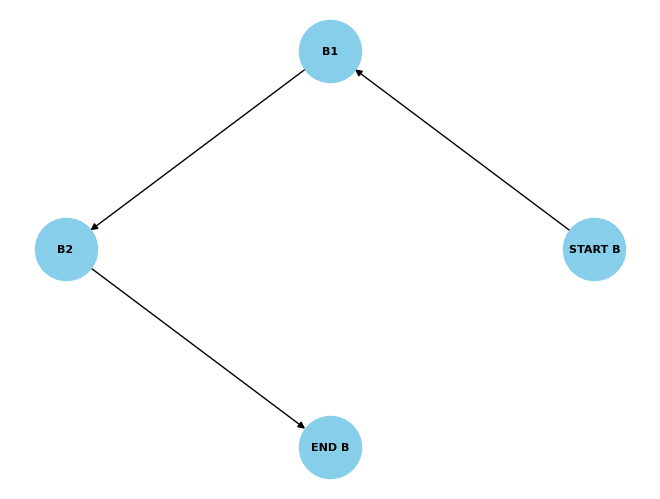

In [10]:
# Create a directed graph
B = nx.DiGraph(section='B')

# Add nodes and edges
B.add_node("START B", response=f"‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á‡πÉ‡∏ô‡πÇ‡∏≠‡∏Å‡∏≤‡∏™‡∏ó‡∏µ‡πà ‡∏ò‡∏ô‡∏≤‡∏Ñ‡∏≤‡∏£{comany_name} ‡πÑ‡∏î‡πâ‡∏à‡∏±‡∏î‡∏ï‡∏±‡πâ‡∏á‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó {comany_name} ‡∏à‡∏≥‡∏Å‡∏±‡∏î ‡πÄ‡∏Ç‡πâ‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó‡πÉ‡∏ô‡∏Å‡∏•‡∏∏‡πà‡∏°‡∏ò‡∏∏‡∏£‡∏Å‡∏¥‡∏à‡∏Å‡∏≤‡∏£‡πÄ‡∏á‡∏¥‡∏ô‡∏Ç‡∏≠‡∏á‡∏ò‡∏ô‡∏≤‡∏Ñ‡∏≤‡∏£ ‡πÇ‡∏î‡∏¢‡∏°‡∏µ‡∏ß‡∏±‡∏ï‡∏ñ‡∏∏‡∏õ‡∏£‡∏∞‡∏™‡∏á‡∏Ñ‡πå‡∏õ‡∏£‡∏∞‡∏Å‡∏≠‡∏ö‡∏Å‡∏¥‡∏à‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡πá‡∏ô‡∏ô‡∏≤‡∏¢‡∏´‡∏ô‡πâ‡∏≤‡∏õ‡∏£‡∏∞‡∏Å‡∏±‡∏ô‡∏ß‡∏¥‡∏ô‡∏≤‡∏®‡∏†‡∏±‡∏¢ {pronoun} {bot_name} ‡∏à‡∏∂‡∏á‡∏ï‡∏¥‡∏î‡∏ï‡πà‡∏≠‡∏°‡∏≤‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏Ç‡∏≠‡∏≠‡∏ô‡∏∏‡∏ç‡∏≤‡∏ï‡∏ô‡∏≥‡πÄ‡∏™‡∏ô‡∏≠‡πÅ‡∏ú‡∏ô‡∏õ‡∏£‡∏∞‡∏Å‡∏±‡∏ô‡∏†‡∏±‡∏¢‡∏£‡∏ñ‡∏¢‡∏ô‡∏ï‡πå‡πÅ‡∏ö‡∏ö‡∏û‡∏¥‡πÄ‡∏®‡∏©‡πÄ‡∏â‡∏û‡∏≤‡∏∞‡∏•‡∏π‡∏Å‡∏Ñ‡πâ‡∏≤‡∏Ç‡∏≠‡∏á‡∏ò‡∏ô‡∏≤‡∏Ñ‡∏≤‡∏£{comany_name}‡πÄ‡∏ó‡πà‡∏≤‡∏ô‡∏±‡πâ‡∏ô {pronoun}‡∏Ç‡∏≠‡∏ä‡∏µ‡πâ‡πÅ‡∏à‡∏á‡∏£‡∏≤‡∏¢‡∏•‡∏∞‡πÄ‡∏≠‡∏µ‡∏¢‡∏î‡∏ô‡∏∞{sentence_ending[1]} ")
B.add_node("B1", response=f"‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÉ‡∏´‡πâ‡∏ó‡πà‡∏≤‡∏ô‡∏™‡∏°‡∏≤‡∏ä‡∏¥‡∏Å‡πÑ‡∏î‡πâ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∞‡πÇ‡∏¢‡∏ä‡∏ô‡πå‡∏™‡∏π‡∏á‡∏™‡∏∏‡∏î ‡∏à‡∏∂‡∏á‡∏Ç‡∏≠‡∏≠‡∏ô‡∏∏‡∏ç‡∏≤‡∏ï‡∏™‡∏≠‡∏ö‡∏ñ‡∏≤‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏£‡∏ñ‡∏¢‡∏ô‡∏ï‡πå‡∏Ç‡∏≠‡∏á‡∏Ñ‡∏∏‡∏ì{customer_name} ‡∏ô‡∏∞{sentence_ending[1]}")
B.add_node("B2", response=f"‡∏£‡∏ñ‡∏¢‡∏ô‡∏ï‡πå‡∏°‡∏µ‡∏õ‡∏£‡∏∞‡∏Å‡∏±‡∏ô‡∏õ‡∏£‡∏∞‡πÄ‡∏†‡∏ó‡πÉ‡∏î (1,2,3,2+,3+) ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∞‡∏Å‡∏±‡∏ô‡∏†‡∏±‡∏¢‡πÇ‡∏î‡∏¢‡∏ö‡∏£‡∏¥‡∏©‡∏±‡∏ó‡∏Ø‡πÉ‡∏î ‡∏™‡∏¥‡πâ‡∏ô‡∏™‡∏∏‡∏î‡∏Ñ‡∏ß‡∏≤‡∏°‡∏Ñ‡∏∏‡πâ‡∏°‡∏Ñ‡∏£‡∏≠‡∏á‡πÄ‡∏°‡∏∑‡πà‡∏≠‡πÉ‡∏î")
B.add_node("END B", response=f"{comany_name}‡πÑ‡∏î‡πâ‡∏Ñ‡∏±‡∏î‡∏™‡∏£‡∏£‡∏Ñ‡πå‡πÅ‡∏ö‡∏ö‡∏õ‡∏£‡∏∞‡∏Å‡∏±‡∏ô ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÄ‡∏õ‡πá‡∏ô‡∏ó‡∏≤‡∏á‡πÄ‡∏•‡∏∑‡∏≠‡∏Å‡∏ó‡∏µ‡πà‡∏Ñ‡∏∏‡πâ‡∏°‡∏Ñ‡πà‡∏≤‡πÑ‡∏ß‡πâ‡∏ö‡∏£‡∏¥‡∏Å‡∏≤‡∏£‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏•‡∏π‡∏Å‡∏Ñ‡πâ‡∏≤‡∏Ç‡∏≠‡∏á‡∏ò‡∏ô‡∏≤‡∏Ñ‡∏≤‡∏£{comany_name} ‡∏î‡∏±‡∏á‡∏ô‡∏µ‡πâ")

B.add_edges_from((("START B","B1"),("B1","B2"),("B2","END B")))

# Plot the graph with responses
pos = nx.circular_layout(B)
nx.draw(B, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=8, font_color='black', font_weight='bold')
plt.show()


In [11]:
# current_node = "START B"
# while True:
#     print("Bot:", B.nodes[current_node]["response"])
    
#     if "END" not in current_node:
#         user_input = input("User: ")
#         print("User:", user_input)

#         if "intent_classify"  in B.nodes[current_node]:
#             intent = B.nodes[current_node]["intent_classify"](user_input)

#         next_nodes = list(B.successors(current_node))

#         if len(next_nodes) == 1:
#             current_node = next_nodes[0]
#         else:
#             if intent == "‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ":
#                 current_node = next_nodes[0]
#             else:
#                 current_node = next_nodes[1]
    
#     else:
#         break

## ALL Bot dialog

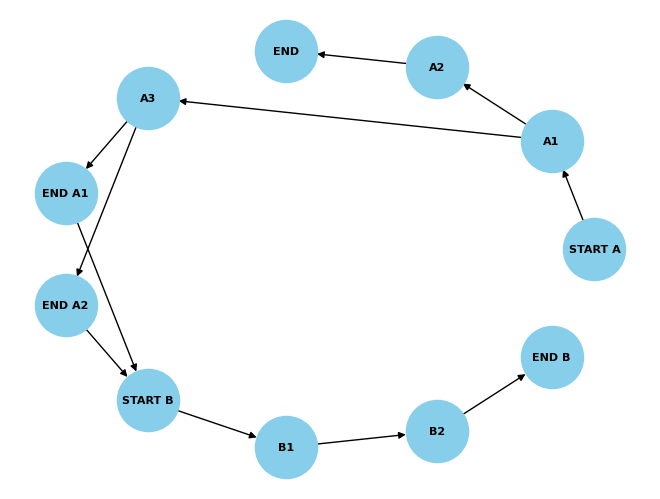

In [12]:
Bot_dialog = nx.compose(A, B)
Bot_dialog.add_edges_from((("END A1","START B"),("END A2","START B")))
pos = nx.circular_layout(Bot_dialog)
nx.draw(Bot_dialog, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=8, font_color='black', font_weight='bold')
plt.show()

In [13]:
# current_node = "START A"
# while True:
#     print("Bot:", Bot_dialog.nodes[current_node]["response"])
#     next_nodes = list(Bot_dialog.successors(current_node))
    
#     if next_nodes != []:
#         user_input = input("User: ")
#         print("User:", user_input)

#         if "intent_classify"  in Bot_dialog.nodes[current_node]:
#             intent = Bot_dialog.nodes[current_node]["intent_classify"](user_input)

#         if len(next_nodes) == 1:
#             current_node = next_nodes[0]
#         else:
#             if intent == "‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ":
#                 current_node = next_nodes[0]
#             else:
#                 current_node = next_nodes[1]

#     else:
#         break

## UI

In [14]:
# import gradio as gr
# import time

# current_node = "START A"
# def user(user_input, history):
#         global current_node, Bot_dialog
        
#         next_nodes = list(Bot_dialog.successors(current_node))
    
#         if next_nodes != []:
#             if "intent_classify"  in Bot_dialog.nodes[current_node]:
#                 intent = Bot_dialog.nodes[current_node]["intent_classify"](user_input)

#             if len(next_nodes) == 1:
#                 current_node = next_nodes[0]
#             else:
#                 if intent == "‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ ‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ":
#                     current_node = next_nodes[0]
#                 else:
#                     current_node = next_nodes[1]

#         return "", history + [[user_input, None]]
        
# def bot(history):
#     global current_node, Bot_dialog
#     history[-1][1] = ""
#     bot_message = Bot_dialog.nodes[current_node]["response"]

#     if current_node == "END B" or current_node == "END":
#         bot_message += """<span style="color:red"> \n**Conversation Ended** </span>"""

#     for character in bot_message:
#         history[-1][1] += character
#         time.sleep(0.01)
#         yield history
        
# def restart(history):
#     global current_node, Bot_dialog
#     current_node = "START A"
#     return [history[0]]

# with gr.Blocks(title="Voicebot Chatbot Demo") as demo:
#     with gr.Column(variant="panel"):
#         gr.Markdown("")
#         chatbot = gr.Chatbot(
#             [[None, Bot_dialog.nodes["START A"]["response"]]],
#             elem_id="chatbot",
#             bubble_full_width=False,
#             avatar_images=('https://aui.atlassian.com/aui/9.3/docs/images/avatar-person.svg','https://avatars.githubusercontent.com/u/51063788?s=200&v=4')
#         )
#         with gr.Group():
#             with gr.Row():
#                 textbox = gr.Textbox(
#                                     container=False,
#                                     show_label=False,
#                                     label="Message",
#                                     placeholder="Enter text and press enter...",
#                                     scale=7,
#                                     autofocus=True,
#                                 )
#         with gr.Row():
#             restart_btn = gr.Button("üîÑ  Restart", variant="secondary")

#     textbox.submit(user, [textbox, chatbot], [textbox, chatbot], queue=False).then(bot, chatbot, chatbot)
#     restart_btn.click(restart,chatbot, chatbot)

# demo.queue().launch(debug=False, share=True)

In [15]:
# import gradio as gr
# import time

# class ChatbotApp:
#     def __init__(self, bot_dialog):
#         self.current_node = "START A"
#         self.bot_dialog = bot_dialog

#     def user(self, user_input, history):
#         next_nodes = list(self.bot_dialog.successors(self.current_node))

#         if next_nodes != []:
#             if "intent_classify" in self.bot_dialog.nodes[self.current_node]:
#                 intent = self.bot_dialog.nodes[self.current_node]["intent_classify"](user_input)

#             if len(next_nodes) == 1:
#                 self.current_node = next_nodes[0]
#             else:
#                 if intent == "‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ ‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏ï‡∏Å‡∏•‡∏á ‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡πÑ‡∏î‡πâ":
#                     self.current_node = next_nodes[0]
#                 else:
#                     self.current_node = next_nodes[1]

#         return "", history + [[user_input, None]]

#     def bot(self, history):
#         history[-1][1] = ""
#         bot_message = self.bot_dialog.nodes[self.current_node]["response"]

#         if self.current_node == "END B" or self.current_node == "END":
#             bot_message += """<span style="color:red"> \n**Conversation Ended** </span>"""

#         for character in bot_message:
#             history[-1][1] += character
#             time.sleep(0.01)
#             yield history

#     def restart(self, history):
#         self.current_node = "START A"
#         return [history[0]]

# # Define your Bot_dialog edges and nodes here
# chatbot_app = ChatbotApp(Bot_dialog)

# with gr.Blocks(title="Voicebot Chatbot Demo") as demo:
#     with gr.Column(variant="panel"):
#         gr.Markdown("")
#         chatbot = gr.Chatbot(
#             [[None, Bot_dialog.nodes["START A"]["response"]]],
#             elem_id="chatbot",
#             bubble_full_width=False,
#             avatar_images=('https://aui.atlassian.com/aui/9.3/docs/images/avatar-person.svg',
#                            'https://avatars.githubusercontent.com/u/51063788?s=200&v=4')
#         )
#         with gr.Group():
#             with gr.Row():
#                 textbox = gr.Textbox(
#                     container=False,
#                     show_label=False,
#                     label="Message",
#                     placeholder="Enter text and press enter...",
#                     scale=7,
#                     autofocus=True,
#                 )
#         with gr.Row():
#             restart_btn = gr.Button("üîÑ  Restart", variant="secondary")

#     textbox.submit(chatbot_app.user, [textbox, chatbot], [textbox, chatbot], queue=False).then(chatbot_app.bot, chatbot, chatbot)
#     restart_btn.click(chatbot_app.restart, chatbot, chatbot)

# demo.queue().launch(debug=False)

In [16]:
import speech_recognition as sr

def transcribe(voicefile_path: str) -> str:
    recognizer = sr.Recognizer()
    try:
        with sr.WavFile(voicefile_path) as source:
            audio = recognizer.record(source)
        transcription = recognizer.recognize_google(audio,language = "th-TH")
        return transcription
    except:
        return "Could not understand audio"

# Will be triggered on voice submit (will transribe and send to generate_speech)
def add_file(voicefile_path:str,history:list):
  print(voicefile_path)
  history = [] if history is None else history
  text = transcribe(voicefile_path)
  history = history + [(text, None)]
  return voicefile_path,history

In [22]:
import gradio as gr
import time
# Create a Gradio interface
with gr.Blocks(title='Chatbot Demo') as demo:
    gr.Markdown('DESCRIPTION HERE')

    chatbot = gr.Chatbot(
         [[None, Bot_dialog.nodes["START A"]["response"]]],
        elem_id="chatbot",
        bubble_full_width=False,
        avatar_images=('https://aui.atlassian.com/aui/9.3/docs/images/avatar-person.svg',
                           'https://avatars.githubusercontent.com/u/51063788?s=200&v=4')
    )

    with gr.Row():
        txt = gr.Textbox(
            scale=3,
            show_label=False,
            placeholder="Enter text and press enter, or speak to your microphone",
            container=False,
            interactive=True,
        )
        txt_btn = gr.Button(value="Submit text", scale=1)
        voice_btn = gr.Audio(sources="microphone",type="filepath", scale=4, streaming=True)

    with gr.Row():
        sentence = gr.Textbox(visible=False)
        audio = gr.Audio(
            value=None,
            label="Generated audio response",
            streaming=True,
            autoplay=True,
            interactive=False,
            show_label=True,
        )

    clear_btn = gr.ClearButton([chatbot, audio,txt])

    voice_msg =  voice_btn.stop_recording(add_file, [voice_btn,chatbot], [txt,chatbot], queue=False)#.then(bot_respond,chatbot,chatbot).then(generate_speech,chatbot,audio)

    # clear_btn.click(lambda: None,None,None, None, [chatbot,audio,txt], queue=False)

demo.launch(debug=False)

AttributeError: 'Audio' object has no attribute 'end'